# Option Pricing with big samples

## Lookback Options

In [1]:
from src.data.make_dataset import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [2]:
# Specify the data loader parameters
n = 40000
n_steps = 10000
n_periods = n_steps/10000
gbm_params = {
    "S0": 1., 
    "mu": 0.05,
    "sigma": 0.2, 
    "T": n_periods, 
    "n_points": n_steps+1, 
    "n": n
}

gbm_loader = DataLoader(method="GBM", params=gbm_params, seed=42)
paths_df = gbm_loader.create_dataset(output_type="DataFrame")

In [3]:
annualization_factor = (paths_df.shape[1]-1)/n_periods
log_returns_df = np.log(paths_df).diff(axis=1).iloc[:, 1:]
print("Input mean:\t", np.mean(paths_df.iloc[:, -1]))
print("Expected mean:\t", np.exp(0.05*n_periods))
print("-------------------------------------")
print("Ann. pat stdev:\t", log_returns_df.std(axis=1).mean()*np.sqrt(annualization_factor))
print("Exp. stdev:\t", 0.2)

Input mean:	 1.0497330173058472
Expected mean:	 1.0512710963760241
-------------------------------------
Ann. pat stdev:	 0.20000485515478889
Exp. stdev:	 0.2


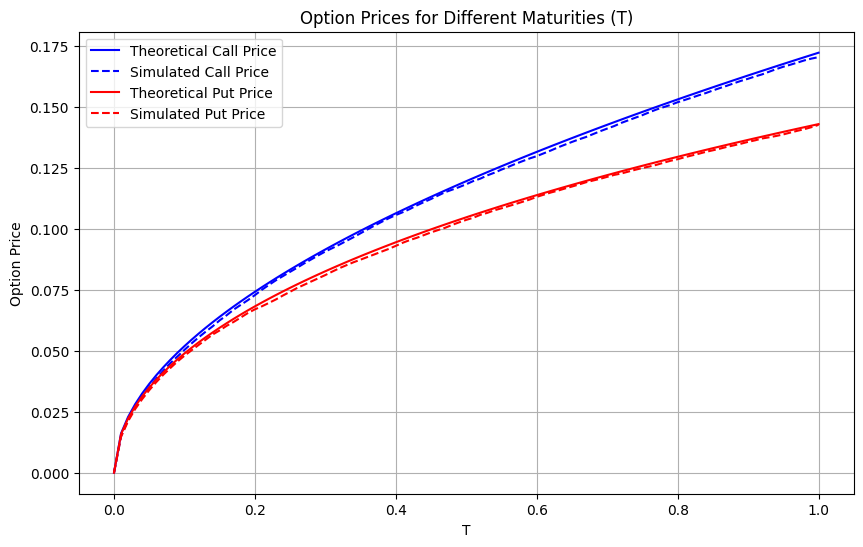

In [4]:
# Parameters
S0 = 1
r = 0.05
T = n_periods
t = 0
sigma = 0.2

# Define the functions for European call and put
lookback_call = lambda x: np.maximum(x.iloc[:, -1] - x.min(axis=1), 0)
lookback_put = lambda x: np.maximum(x.max(axis=1) - x.iloc[:, -1], 0)

# Store results
T_values = []
exact_call_prices = []
exact_put_prices = []
mc_call_ul_prices = []
mc_put_ul_prices = []

for i, T_cur in enumerate(paths_df.columns):
    if i % 100 != 0 and T_cur != T:
        continue
    d = (r + sigma**2/2)*np.sqrt(T_cur-t)/sigma

    exact_call_price = S0*(
        norm.cdf(d) - 
        np.exp(-r*(T_cur-t))*norm.cdf(d-sigma*np.sqrt(T_cur-t)) - 
        sigma**2/(2*r)*norm.cdf(-d) +
        np.exp(-r*(T_cur-t))*sigma**2/(2*r)*norm.cdf(d-sigma*np.sqrt(T_cur-t))
    )
    exact_put_price = S0*(
        -norm.cdf(-d) + 
        np.exp(-r*(T_cur-t))*norm.cdf(-d+sigma*np.sqrt(T_cur-t)) +
        sigma**2/(2*r)*norm.cdf(d) -
        np.exp(-r*(T_cur-t))*sigma**2/(2*r)*norm.cdf(-d+sigma*np.sqrt(T_cur-t))
    )

    mc_call_ul_price = np.mean(np.exp(-r*(T_cur-t))*lookback_call(paths_df.iloc[:, :(i+1)]))
    mc_put_ul_price = np.mean(np.exp(-r*(T_cur-t))*lookback_put(paths_df.iloc[:, :(i+1)]))

    T_values.append(T_cur)
    exact_call_prices.append(exact_call_price)
    exact_put_prices.append(exact_put_price)
    mc_call_ul_prices.append(mc_call_ul_price)
    mc_put_ul_prices.append(mc_put_ul_price)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(T_values, exact_call_prices, 'b', label='Theoretical Call Price')
plt.plot(T_values, mc_call_ul_prices, 'b--', label='Simulated Call Price')
plt.plot(T_values, exact_put_prices, 'r', label='Theoretical Put Price')
plt.plot(T_values, mc_put_ul_prices, 'r--', label='Simulated Put Price')

plt.xlabel('T')
plt.ylabel('Option Price')
plt.title('Option Prices for Different Maturities (T)')
plt.legend()
plt.grid(True)
plt.show()

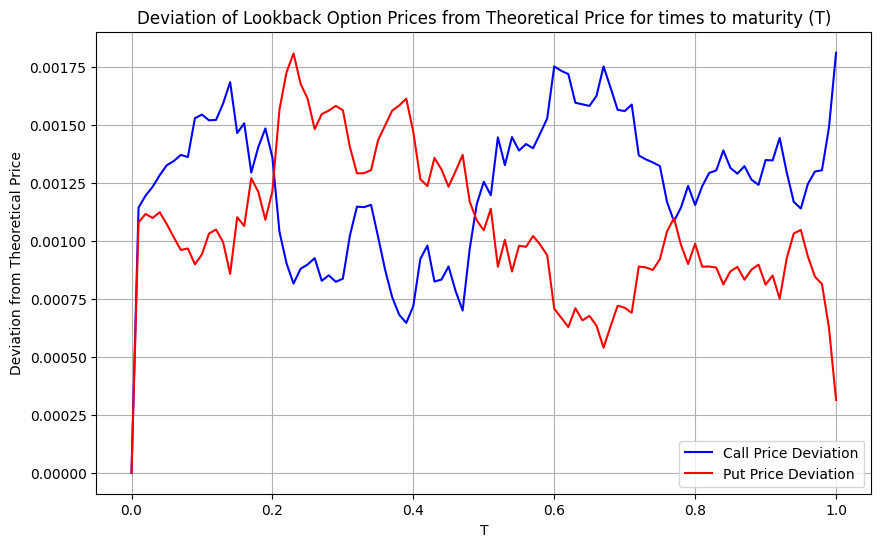

In [5]:
# Store results
ul_call_deviations = abs(np.array(mc_call_ul_prices) - np.array(exact_call_prices))
ul_put_deviations = abs(np.array(mc_put_ul_prices) - np.array(exact_put_prices))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(T_values, ul_call_deviations, 'b' ,label='Call Price Deviation')
plt.plot(T_values, ul_put_deviations, 'r',label='Put Price Deviation')

plt.xlabel('T')
plt.ylabel('Deviation from Theoretical Price')
plt.title('Deviation of Lookback Option Prices from Theoretical Price for times to maturity (T)')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\peter\OneDrive - TUM\Master TUM\Masterarbeit\MarketGenerators\.venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
c:\Users\peter\OneDrive - TUM\Master TUM\Masterarbeit\MarketGenerators\.venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


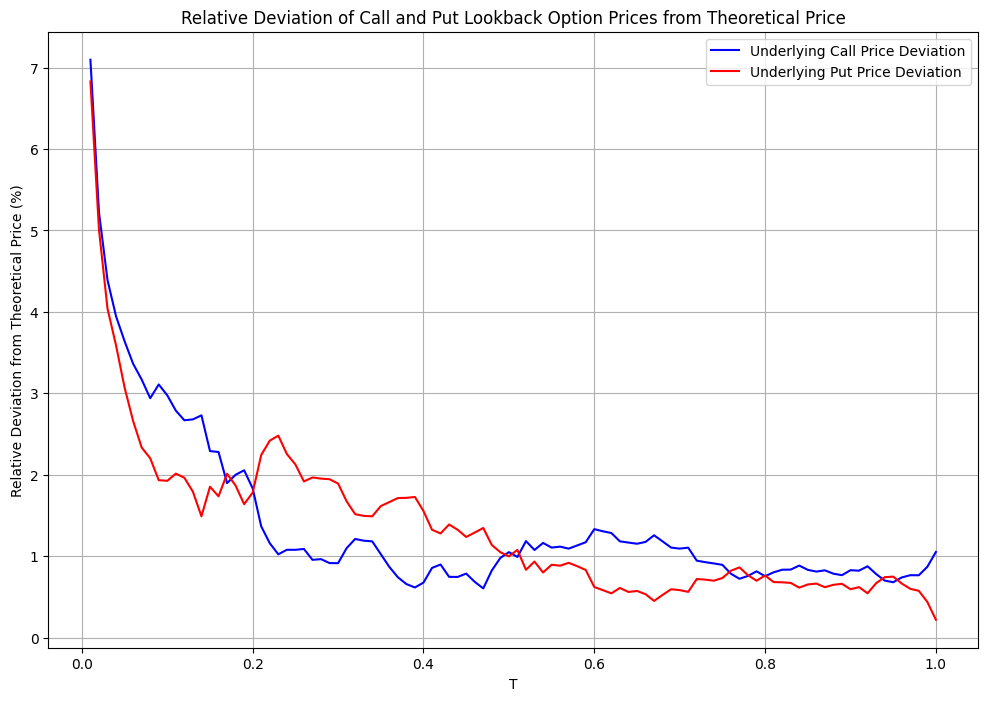

In [6]:
ul_call_deviations_rel = ul_call_deviations / np.array(exact_call_prices) * 100
ul_put_deviations_rel = ul_put_deviations / np.array(exact_put_prices) * 100

# Plot the results
plt.figure(figsize=(12, 8))

plt.plot(T_values, ul_call_deviations_rel, 'b', label='Underlying Call Price Deviation')
plt.plot(T_values, ul_put_deviations_rel, 'r', label='Underlying Put Price Deviation')

plt.xlabel('T')
plt.ylabel('Relative Deviation from Theoretical Price (%)')
plt.title('Relative Deviation of Call and Put Lookback Option Prices from Theoretical Price')
plt.legend()
plt.grid(True)
plt.show()